# Import packages

In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sys
import forceatlas2
from fa2 import ForceAtlas2
import igraph
import cairocffi

from matplotlib.cm import get_cmap

# Define custom functions

In [2]:
from utils import *

# Import data

## Estimated networks

In [3]:
# Parameters
date = "2008-09-15"
ts_type = "volatility"

# Iterables
methods = ['NS','SPACE','GLASSO','DY_Lasso','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing_demirer_playground(date,method,ts_type)

## Variable names

In [4]:
df = pd.read_csv('./Data/Stock_prices/Demirer2017_dataset.csv',sep=";", header=0)

print(df.head())

   dd/mm/yy   hsba.ln  X8306.to    bnp.fr       jpm    dbk.xe   barc.ln  \
0  12/09/03  0.000081  0.000258  0.000473  0.000130  0.000163  0.000457   
1  15/09/03  0.000028  0.000258  0.000204  0.000103  0.000155  0.000112   
2  16/09/03  0.000070  0.001790  0.000227  0.000111  0.000188  0.000155   
3  17/09/03  0.000061  0.000731  0.000223  0.000042  0.000327  0.000109   
4  18/09/03  0.000066  0.000622  0.000260  0.000393  0.000309  0.000171   

     aca.fr       bac         c  ...      US_b      UK_b     GER_b     FRA_b  \
0  0.000116  0.000052  0.000055  ...  0.000075  0.000047  0.000062  0.000069   
1  0.000154  0.000091  0.000072  ...  0.000028  0.000008  0.000007  0.000008   
2  0.000152  0.000036  0.000045  ...  0.000016  0.000011  0.000006  0.000005   
3  0.000148  0.000032  0.000205  ...  0.000060  0.000009  0.000010  0.000011   
4  0.000159  0.000148  0.000355  ...  0.000054  0.000014  0.000017  0.000017   

      ITA_b     ESP_b     GRC_b     JPN_b     CAN_b     AUS_b  
0  0

In [5]:
var_names = list(df.columns)[1:]

print(var_names)

['hsba.ln', 'X8306.to', 'bnp.fr', 'jpm', 'dbk.xe', 'barc.ln', 'aca.fr', 'bac', 'c', 'X8411.to', 'gle.fr', 'rbs.ln', 'X8316.to', 'san.mc', 'wfc', 'inga.ae', 'lloy.ln', 'ucg.mi', 'ubsn.vx', 'csgn.vx', 'gs', 'ndasek.sk', 'isp.mi', 'MS', 'td.t', 'ry.t', 'bbva.mc', 'cbk.xe', 'nab.au', 'bns.t', 'cba.au', 'stan.ln', 'X600036.sh', 'anz.au', 'wbc.au', 'X600000.sh', 'danske.ko', 'sber.mz', 'X600016.sh', 'bmo.t', 'itub4.br', 'X8308.to', 'X8604.to', 'X8309.to', 'sbin.in', 'dnb.os', 'shba.sk', 'seba.sk', 'cm.t', 'bk.us', 'usb', 'bbdc4.br', 'kbc.bt', 'pnc.us', 'd05.sg', 'X000001.sz', 'X053000.se', 'dexb.bt', 'cof', 'X055550.se', 'sweda.sk', 'X600015.sh', 'ebs.vi', 'bmps.mi', 'stt.us', 'sab.mc', 'u11.sg', 'pop.mc', 'X024110.SE', 'BBT', 'bir.db', 'NA.T', 'STI.US', 'bp.mi', 'maybank.ku', 'aib.db', 'sbk.jo', 'AXP', 'ete.at', 'mqg.au', 'X8354.to', 'X8332.to', 'poh1s.he', 'fitb.us', 'rf.us', 'X8331.to', 'uni.mi', 'bcp.lb', 'cimb.ku', 'bankbaroda.in', 'isctr.is', 'bes.lb', 'X8377.to', 'X8355.to', 'mb.mi', 

## Variable metadata (country etc)

In [7]:
var_metadata = pd.read_excel('./Data/Stock_prices/Bank_tickers.xlsx')

print(var_metadata.head())

             Bank Name Country Bank Code Reuters Ticker Yahoo Finance Ticker
0  JPMorgan Chase & Co      US    jpm.us            jpm                  JPM
1      Bank of America      US    bac.us            bac                  BAC
2            Citigroup      US      c.us              c                    C
3          Wells Fargo      US    wfc.us            wfc                  WFC
4  Goldman Sachs Group      US     gs.us             gs                   GS


In [21]:
countries = []

for var in var_names:
    try:
        country = str(var_metadata[var_metadata['Reuters Ticker']==var].Country.iloc[0])
        countries.append(country)
        
    except:
        countries.append('Other')

In [24]:
unique_countries = list(pd.value_counts(countries).index)

In [36]:
# Set colors
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors

name2 = "tab20b"
cmap2 = get_cmap(name2)  # type: matplotlib.colors.ListedColormap
colors2 = cmap2.colors

In [39]:
country_colors = []
collen = len(colors)

for country in countries:
    loc = unique_countries.index(country)
    if loc < collen:
        country_colors.append(colors[loc])
        
    else:
        country_colors.append(colors2[loc-collen])

# Centrality measure comparisons

In [40]:
# Parameters
varnames = var_names
centrality_type = "closeness" #"betweenness" #"katz-bonacich"
cross_holdings = False
asset_sizes = False

# Create centrality rankings
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    
# Create centrality rankings
ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

# Inspect the dataframe
display(ranking_df)

NS
SPACE
GLASSO
DY_Lasso
DAG


,NS,SPACE,GLASSO,DY_Lasso,DAG
0,gs,csgn.vx,bbva.mc,bcp.lb,GRC_b
1,ubsn.vx,MS,dbk.xe,sbin.in,ITA_b
2,c,bbva.mc,wfc,sber.mz,X8411.to
3,wfc,dbk.xe,barc.ln,bac,gs
4,dbk.xe,jpm,aca.fr,rbs.ln,FRA_b
...,...,...,...,...,...
101,X8355.to,itub4.br,cimb.ku,ESP_b,US_b
102,mb.mi,wbc.au,bankbaroda.in,GRC_b,UK_b
103,X8418.to,sber.mz,X8377.to,JPN_b,JPN_b
104,UK_b,X600016.sh,X8418.to,CAN_b,CAN_b


# Ranking visualisation

## Method 'winners'

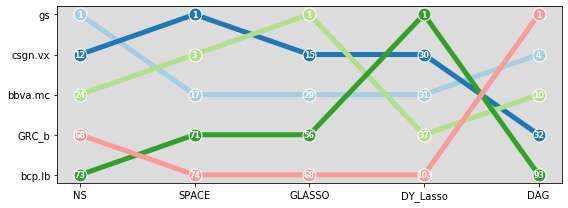

In [46]:
# Parameters
chosen_varnames = list(ranking_df.loc[0])

# Run the visualisation function
rank_viz_demirer_playground(chosen_varnames,ranking_df,centrality_type,date,ts_type)

## Custom selection

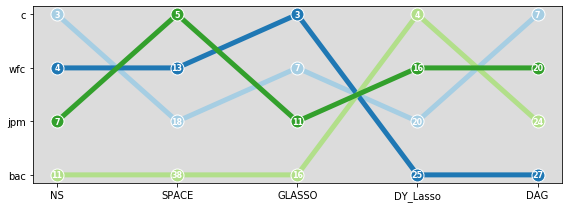

In [41]:
# Parameters
chosen_varnames = ["c","wfc","bac","jpm"]

# Run the visualisation function
rank_viz_demirer_playground(chosen_varnames,ranking_df,centrality_type,date,ts_type)

# Visualise network

Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

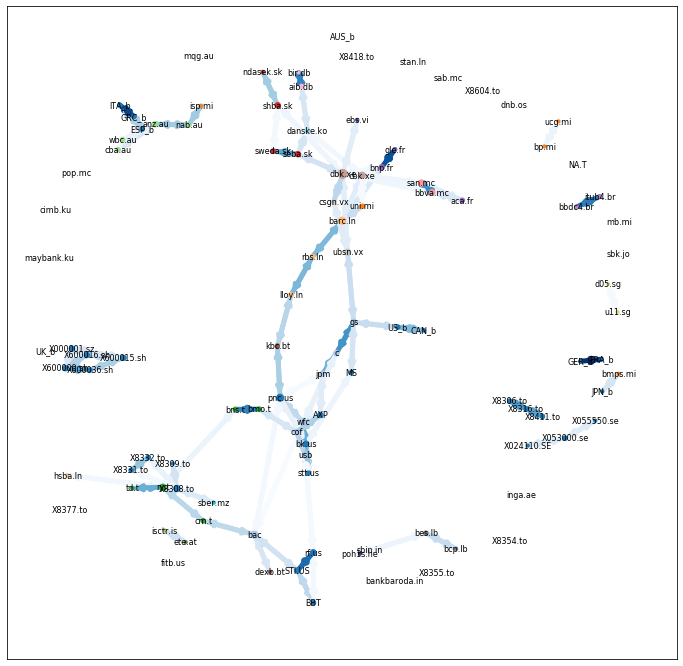

Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

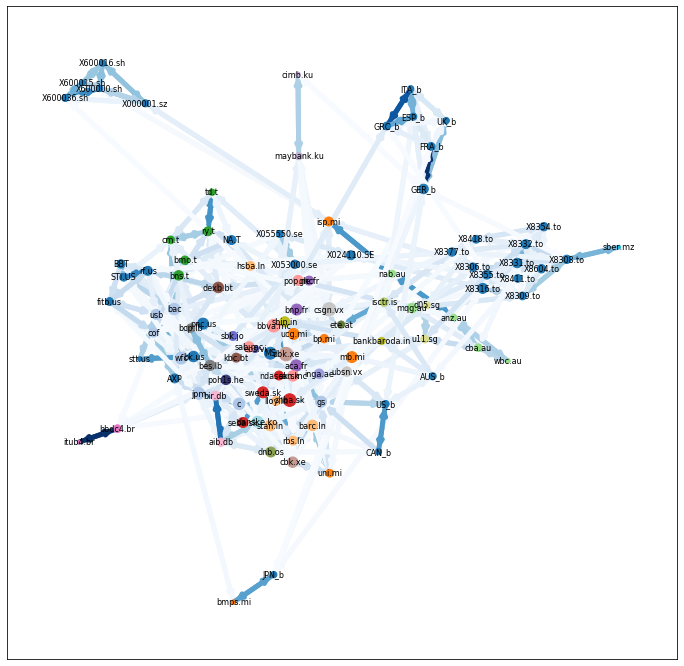

Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

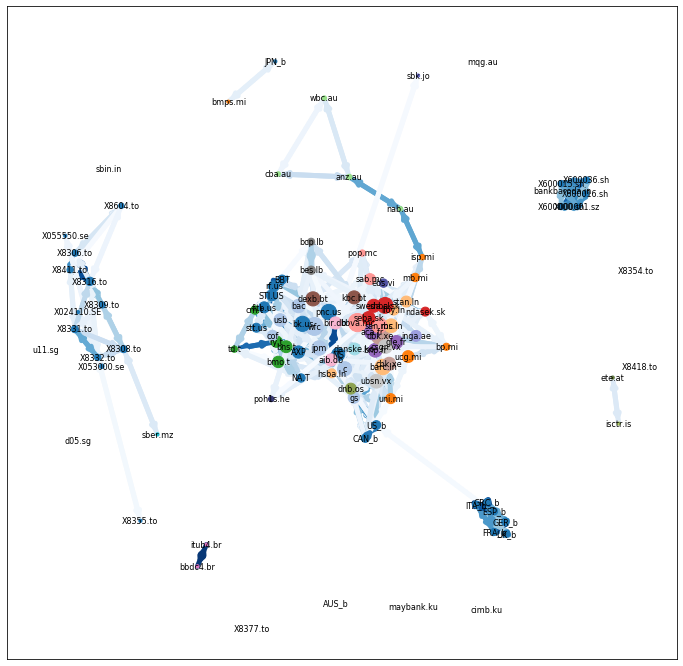

Method: DY_Lasso


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

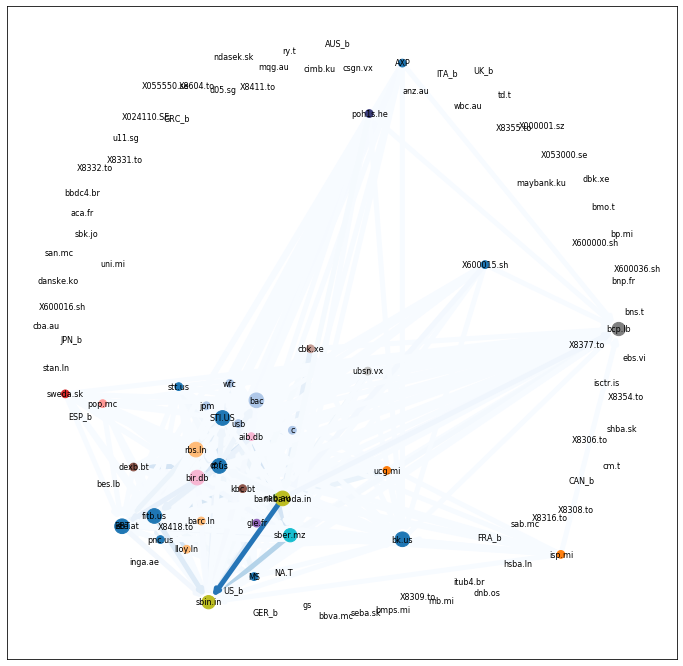

Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

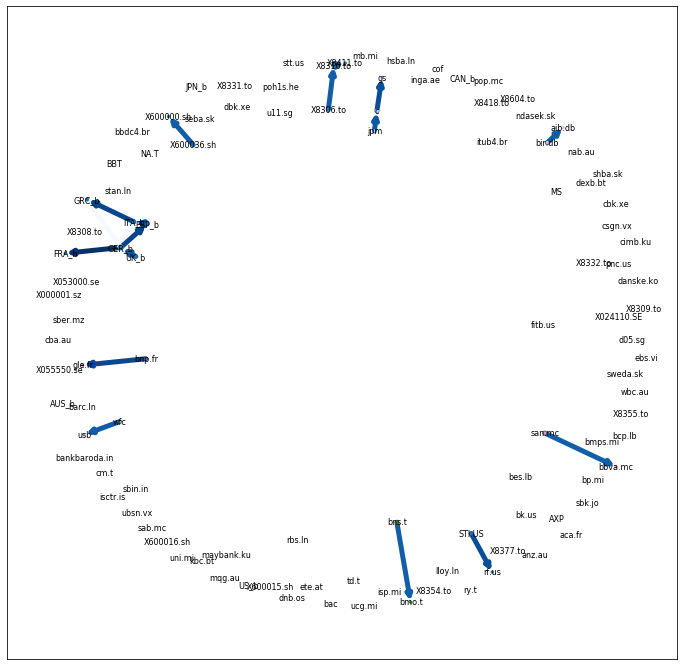

In [45]:
# Parameters
date = "2008-09-15"
ts_type = "volatility"

# Iterables
methods = ['NS','SPACE','GLASSO','DY_Lasso','DAG']

for method in methods:
    
    large_network_viz(date,method,ts_type,var_names,country_colors)

# Support

In [45]:
label_dict = {}

for i in range(0,len(var_names)):
    label_dict[i] = var_names[i]
    
# Relabel network
G = nx.relabel_nodes(G, label_dict)

In [46]:
# Get edge weights
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

In [47]:
# Customize ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.2, #1.0,

                        # Log
                        verbose=True)

In [48]:
# Parameters
plt.rcParams['figure.figsize'] = (12,12)

# Get degrees
degree_demirer = dict(G.degree)

#node_pos = forceatlas2.forceatlas2_networkx_layout(G, niter=1000)
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2476.97it/s]

BarnesHut Approximation  took  0.21  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

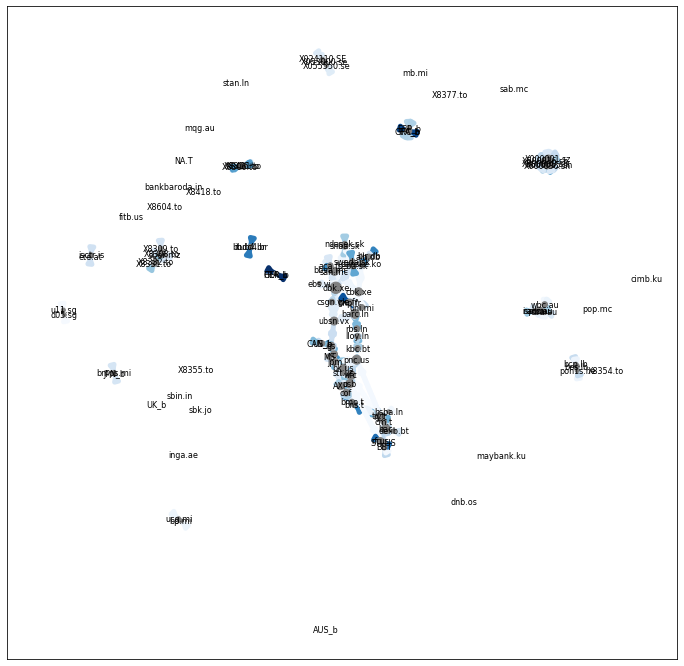

In [49]:
# Draw network
nx.draw_networkx(G,node_pos,
                     #nodelist=degree_mcc_network.keys(),
                     node_size=[v * 8 for v in degree_demirer.values()],
                     #node_color=colors,
                     font_size=8, node_color='grey',
                 edgelist=edges,
                 edge_color=weights,
                 width=5.0, edge_cmap=plt.cm.Blues,
                     with_labels=True)

plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)

In [52]:
# equivalently
GI = igraph.Graph.TupleList(G.edges(), directed=False)
layout = forceatlas2.forceatlas2_igraph_layout(GI, pos=None, iterations=2000)
igraph.plot(GI).show()

100%|██████████| 2000/2000 [00:00<00:00, 3438.58it/s]


BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.26  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

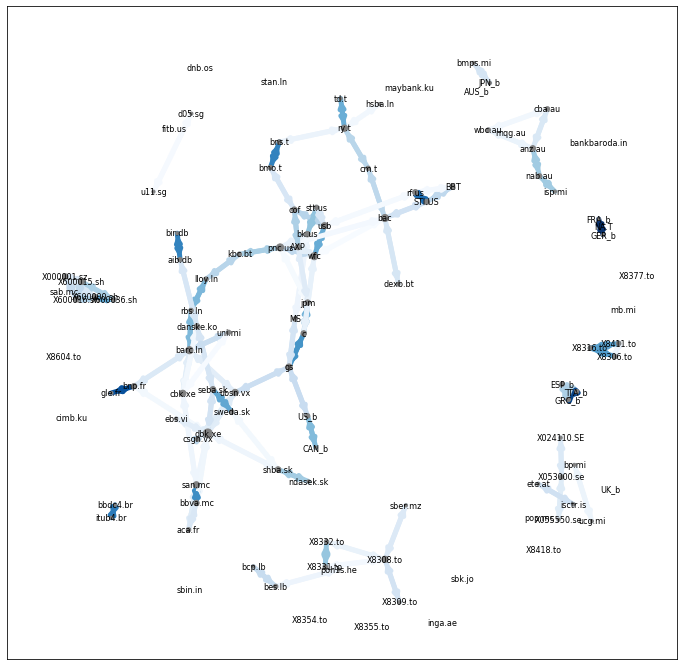

Method: DY_Lasso


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

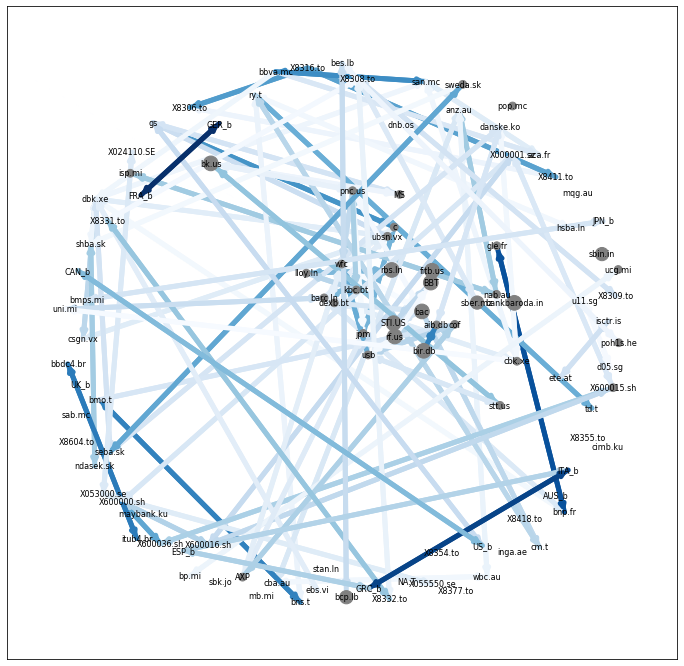

In [53]:
# Iterable (Methods to check)
methods = ["NS","DY_Lasso"]

# Other parameters
date = "2008-09-15"
ts_type = "volatility"

for method in methods:
    
    print("Method: {}".format(method))
    
    # Import network
    G = network_preprocessing(date,method,ts_type)
    
    label_dict = {}

    for i in range(0,len(var_names)):
        label_dict[i] = var_names[i]

    # Relabel network
    G = nx.relabel_nodes(G, label_dict)
    
    
    # Parameters
    plt.rcParams['figure.figsize'] = (12,12)

    # Get degrees
    degree_demirer = dict(G.degree)

    # Draw network
    nx.draw_networkx(G,
                         #nodelist=degree_mcc_network.keys(),
                         node_size=[v * 5 for v in degree_demirer.values()],
                         #node_color=colors,
                         font_size=8, node_color='grey',
                     edgelist=edges,
                     edge_color=weights,
                     width=5.0, edge_cmap=plt.cm.Blues,
                         with_labels=True)

    plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)
    plt.show()

In [44]:
# # Really naive example
# nx.draw(G, pos=nx.spring_layout(G))